In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# !tar -xf drive/MyDrive/Heridas_.tar.gz 

In [ ]:
# !tar -xf drive/MyDrive/outmodel.tar.gz

# Modelo Skin Tears actualizado

In [ ]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from sklearn import metrics

import cv2
import time

In [ ]:
# Parametros
N_EPOCHS = 100
BATCH_SIZE = 4

Primero vamos a listar el total de imagenes, de modo que podamos cargarlas en un conjunto de entrenamiento y de test

In [ ]:
test_path = glob("Downloads/Heridas_Test/**/*.png", recursive=True)

#Original
train_path = glob("Downloads/Heridas_Entrenamiento/**/*.png", recursive=True)

#Binario
#train_path = glob("binarios/Heridas_Entrenamiento/**/*.png", recursive=True)

#Zoom
#train_path = glob("zoom15/Heridas_Entrenamiento/**/*.png", recursive=True)

#Sharpen
#train_path = glob("sharpen/Heridas_Entrenamiento/**/*.png", recursive=True)

print(f"tenemos {len(train_path)} imagenes de entrenamiento y {len(test_path)} imagenes de test")

tenemos 62 imagenes de entrenamiento y 23 imagenes de test


## Construcción de dataset
Usaremos `tf.data` de modo de poder preprocesar las imagenes 

In [ ]:
class_names = np.array(sorted(["Type1", "Type2", "Type3"]))


In [ ]:
trainset = tf.data.Dataset.from_tensor_slices(train_path)
trainset = trainset.shuffle(len(train_path), reshuffle_each_iteration=True)

testset = tf.data.Dataset.from_tensor_slices(test_path)

for path in trainset.take(5):
    print(path.numpy())

b'sharpen/Heridas_Entrenamiento/Type1/skinTear5_3.png'
b'sharpen/Heridas_Entrenamiento/Type3/skinTear6_5.png'
b'sharpen/Heridas_Entrenamiento/Type1/skinTear10_2.png'
b'sharpen/Heridas_Entrenamiento/Type1/skinTear5_1.png'
b'sharpen/Heridas_Entrenamiento/Type2/skinTear8_3.png'


In [ ]:
def get_label(path):
    """
    Genera las etiquetas desde el path
    """
    splits = tf.strings.split(path, os.path.sep)
    onehot = splits[-2] == class_names
    return tf.argmax(onehot)

def open_processing(path):
    label = get_label(path)
    b_image = tf.io.read_file(path)
    image = tf.io.decode_png(b_image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def augmentation(image, label):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    
    #image = tf.image.random_crop(image, (300, 300))
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, size=(224,224))
    return image, label

def testresize(image, label):
    image = tf.image.resize(image, size=(224,224))
    return image, label

def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [ ]:
trainset = trainset.map(open_processing, num_parallel_calls=tf.data.AUTOTUNE)
trainset = trainset.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)

testset = testset.map(open_processing, num_parallel_calls=tf.data.AUTOTUNE)
testset = testset.map(testresize, num_parallel_calls=tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen de forma (224, 224, 3), dtypefloat32 y de clase 0


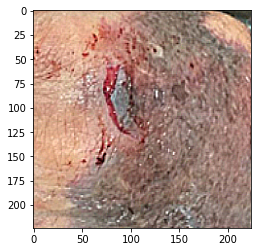

In [ ]:
for img, label in trainset.take(1):
    print(f"Imagen de forma {img.numpy().shape}, dtype{img.numpy().dtype} y de clase {label.numpy()}")
    plt.imshow(img.numpy())

In [ ]:
for img, label in testset.take(1):
    print(f"Imagen de forma {img.numpy().shape}, dtype{img.numpy().dtype} y de clase {label.numpy()}")
    #plt.imshow(img.numpy())

Imagen de forma (224, 224, 3), dtypefloat32 y de clase 0


In [ ]:
#Finalmente, aplicamos batch y precargamos datos
trainset = trainset.shuffle(len(test_path), reshuffle_each_iteration=True)
trainset = trainset.batch(BATCH_SIZE)
trainset = trainset.prefetch(buffer_size=tf.data.AUTOTUNE)

testset = testset.batch(BATCH_SIZE)
testset = testset.prefetch(buffer_size=tf.data.AUTOTUNE)



## Modelo
En el original, utiliza una estructura similar a un AlexNet.
Como esto ya es muy antiguo, vamos a actualizar a un modelo mas 

In [ ]:
# Funcion para decaimiento de Learning Rate
# cambia la tasa de aprendisaje despues de cada epoca, cada vez es mas chica, la tasa de aprendisajes es cuanto pueden cambiar los pesos de cada parametro despues de cada epoca
def scheduler(epoch, lr):
    def decayed_learning_rate(step, decay_steps=500, alpha=0.0, initial_learning_rate=0.001):
        step = min(step,decay_steps)
        cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
        decayed = (1 - alpha) * cosine_decay + alpha
        return initial_learning_rate * decayed
    steps_per_epoch = 62 // BATCH_SIZE #total de imagenes por batch
    step = epoch * steps_per_epoch #se ejecuta cada epoca
    # determinamos que al 80% ya se acerque al minimo.
    alpha_min = int((N_EPOCHS * steps_per_epoch) * 0.8)
    return decayed_learning_rate(step, alpha_min, alpha=1e-4, initial_learning_rate=0.001)

In [ ]:
# Vamos a instanciar una Resnet desde cero, igual podriamos cambiar los pesos a resnet pero esta es una prueba basica.
#Esta red llamada ResNet50V2 no es de las mejores para usar en este contexto ya que tiene demaciados parametros, funciona mejor cuando se tiene un dataset grande.
model = ResNet50V2(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation=None,
)

model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10),
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
]

start_time = time.time()

hist = model.fit(
    trainset,
    validation_data=testset,
    epochs=N_EPOCHS,
    callbacks=callbacks,
)

print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
16/16 [==============================] - 13s 487ms/step - loss: 2.0369 - accuracy: 0.3065 - val_loss: 1.2452 - val_accuracy: 0.4783 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009996145566685496.
Epoch 2/100
16/16 [==============================] - 7s 454ms/step - loss: 1.3098 - accuracy: 0.3226 - val_loss: 1.5646 - val_accuracy: 0.4783 - lr: 9.9961e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009984588209998775.
Epoch 3/100
16/16 [==============================] - 7s 442ms/step - loss: 1.0901 - accuracy: 0.4194 - val_loss: 1.3290 - val_accuracy: 0.4783 - lr: 9.9846e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009965345750546153.
Epoch 4/100
16/16 [==============================] - 7s 421ms/step - loss: 0.7840 - accuracy: 0.6613 - val_loss: 11.3585 - val_accuracy: 0.3043 - lr: 9.9653e-04

Epoch 5: LearningRateScheduler setting learning rate to 0

In [ ]:
#Si se entrenó un modelo, se guarda aqui
os.makedirs("outmodel/", exist_ok=True)
model.save("outmodel")

In [ ]:
#Para cargar el modelo ya entrenado:
model = tf.keras.models.load_model("outmodel_binarios/")
model.summary()

### Graficas desempeño de entrenamiento

In [ ]:
hist_dict = hist.history
print(hist_dict.keys())

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(21, 8))

ax[0].set_title("Loss")
ax[0].plot(hist_dict['loss'], label='train loss')
ax[0].plot(hist_dict['val_loss'], label='val loss')
ax[0].set(xlabel='epochs', ylabel='Loss', ylim=[0,5])
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(hist_dict['accuracy'], label='Train Accuracy')
ax[1].plot(hist_dict['val_accuracy'], label='Val Accuracy')
ax[1].set(xlabel='epochs', ylabel='Accuracy')
ax[1].legend()

ax[2].set_title("Learning Rate")
ax[2].semilogy(hist_dict['lr'])
ax[2].set(xlabel='epochs', ylabel='Learning Rate (log)')

In [ ]:
ytest = []
ypred = []
for image, label in testset:
    pred = model.predict(image)
    ypred.append(pred)
    ytest.append(label.numpy())

print(ypred[0], ytest[0])

In [ ]:
ytest = np.concatenate(ytest, axis=0)
ypred = np.concatenate(ypred, axis=0)

print(np.argmax(ypred, axis=1).shape)

In [ ]:
print(metrics.classification_report(ytest, np.argmax(ypred, axis=1)))

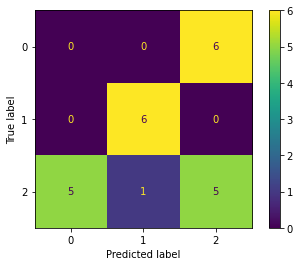

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_true=ytest, y_pred=np.argmax(ypred, axis=1))

# Probar modelos entrenados

In [ ]:
#cargar modelos entrenados
model_original = tf.keras.models.load_model("outmodel_original/")
model_binarios = tf.keras.models.load_model("outmodel_binarios/")
model_zoom = tf.keras.models.load_model("outmodel_zoom/")
model_sharpen = tf.keras.models.load_model("outmodel_sharpen/")

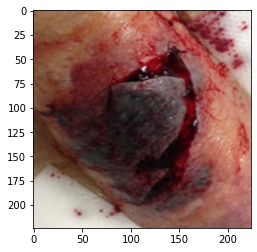

In [ ]:
#seleccionar imagen a clasificar
imtest_path = b"Downloads/Heridas_Test/Type1/skinTear11_1.png"
image, label = open_processing(imtest_path)
image = tf.image.resize(image, (224, 224))
plt.imshow(image.numpy())

In [ ]:
#clasificacion con modelo original
pred = model_original.predict(tf.expand_dims(image, axis=0))
percents = softmax(pred)
print(f"Imagen de etiqueta {label.numpy()} predijo {percents.argmax()} con probabilidad {percents.max() * 100:.3f}%")

1/1 [==============================] - 0s 93ms/step
Imagen de etiqueta 1 predijo 1 con probabilidad 0.000%


In [ ]:
#clasificacion con modelo binarios
pred = model_binarios.predict(tf.expand_dims(image, axis=0))
percents = softmax(pred)
print(f"Imagen de etiqueta {label.numpy()} predijo {percents.argmax()} con probabilidad {percents.max() * 100:.3f}%")

1/1 [==============================] - 0s 84ms/step
Imagen de etiqueta 1 predijo 1 con probabilidad 4.067%


In [ ]:
#clasificacion con modelo zoom
pred = model_zoom.predict(tf.expand_dims(image, axis=0))
percents = softmax(pred)
print(f"Imagen de etiqueta {label.numpy()} predijo {percents.argmax()} con probabilidad {percents.max() * 100:.3f}%")

1/1 [==============================] - 0s 85ms/step
Imagen de etiqueta 1 predijo 2 con probabilidad 0.627%


In [ ]:
#clasificacion con modelo sharpen
pred = model_sharpen.predict(tf.expand_dims(image, axis=0))
percents = softmax(pred)
print(f"Imagen de etiqueta {label.numpy()} predijo {percents.argmax()} con probabilidad {percents.max() * 100:.3f}%")

1/1 [==============================] - 0s 101ms/step
Imagen de etiqueta 0 predijo 1 con probabilidad 1.595%


# Crear datasets con imagenes filtradas

In [ ]:
def open_processing_modificado(path, escala_de_grises = True):
    label = get_label(path)
    if(escala_de_grises == True):
      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
      image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    return image, label

def imagen_a_binario(image):
  image = cv2.threshold(image,127,255,cv2.THRESH_BINARY)[1]
  return image

def zoom_center(img, zoom_factor=1.5):
    y_size = img.shape[0]
    x_size = img.shape[1]   
    # define new boundaries
    x1 = int(0.5*x_size*(1-1/zoom_factor))
    x2 = int(x_size-0.5*x_size*(1-1/zoom_factor))
    y1 = int(0.5*y_size*(1-1/zoom_factor))
    y2 = int(y_size-0.5*y_size*(1-1/zoom_factor))
    # first crop image then scale
    img_cropped = img[y1:y2,x1:x2]
    return cv2.resize(img_cropped, None, fx=zoom_factor, fy=zoom_factor)

def guardar_imagenes_en_binario():
  print(train_path)
  os.makedirs("binarios/Heridas_Entrenamiento/Type1", exist_ok=True)
  os.makedirs("binarios/Heridas_Entrenamiento/Type2", exist_ok=True)
  os.makedirs("binarios/Heridas_Entrenamiento/Type3", exist_ok=True)

  for i in train_path:
    path_donde_guardar = "binarios/"+i.split("/")[1]+"/"+i.split("/")[2]

    image, label = open_processing_modificado(i)
    imagen_en_binario = imagen_a_binario(image)
    
    if(i.split("/")[2] == "Type1"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_en_binario)
    elif(i.split("/")[2] == "Type2"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_en_binario)
    elif(i.split("/")[2] == "Type3"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_en_binario)


def guardar_imagenes_con_zoom():
  print(train_path)
  os.makedirs("zoom15/Heridas_Entrenamiento/Type1", exist_ok=True)
  os.makedirs("zoom15/Heridas_Entrenamiento/Type2", exist_ok=True)
  os.makedirs("zoom15/Heridas_Entrenamiento/Type3", exist_ok=True)

  for i in train_path:
    path_donde_guardar = "zoom15/"+i.split("/")[1]+"/"+i.split("/")[2]

    image, label = open_processing_modificado(i, escala_de_grises=False)
    imagen_con_zoom = zoom_center(image)
    imagen_con_zoom = cv2.cvtColor(imagen_con_zoom, cv2.COLOR_BGR2RGB)
    
    if(i.split("/")[2] == "Type1"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_con_zoom)
    elif(i.split("/")[2] == "Type2"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_con_zoom)
    elif(i.split("/")[2] == "Type3"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_con_zoom)

def guardar_imagenes_con_sharpen():
  print(train_path)
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  os.makedirs("sharpen/Heridas_Entrenamiento/Type1", exist_ok=True)
  os.makedirs("sharpen/Heridas_Entrenamiento/Type2", exist_ok=True)
  os.makedirs("sharpen/Heridas_Entrenamiento/Type3", exist_ok=True)

  for i in train_path:
    path_donde_guardar = "sharpen/"+i.split("/")[1]+"/"+i.split("/")[2]

    image, label = open_processing_modificado(i, escala_de_grises=False)
    imagen_sharpen = cv2.filter2D(src=image, kernel=kernel, ddepth=-1)
    imagen_sharpen = cv2.cvtColor(imagen_sharpen, cv2.COLOR_BGR2RGB)
    
    if(i.split("/")[2] == "Type1"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_sharpen)
    elif(i.split("/")[2] == "Type2"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_sharpen)
    elif(i.split("/")[2] == "Type3"):
      cv2.imwrite(os.path.join(path_donde_guardar , i.split("/")[3]), imagen_sharpen)

# guardar_imagenes_en_binario()
# guardar_imagenes_con_zoom()
# guardar_imagenes_con_sharpen()